# ML Fundamentals in Practice


## Overview

This notebook demonstrates key ML fundamentals through practical examples:

1. **Proper Data Splitting** - Train/Validation/Test sets
2. **Baseline Models** - Simple reference points for comparison
3. **Model Training** - Actual model vs baseline
4. **Training Curves** - Identifying overfitting and underfitting
5. **Regularization** - Controlling model complexity

 Two datasets:
- **Classification:** Breast Cancer detection
- **Regression:** California Housing prices

---
# Part 1: Classification Example (Breast Cancer)

## 1.1 Load Dataset and Explore

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

# Load breast cancer dataset
data = load_breast_cancer()

# Create DataFrame for easier viewing
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print("Dataset Information:")
print("="*60)
print("Total samples:", len(df))
print("Number of features:", len(data.feature_names))
print("\nTarget classes:")
print("  0 = Malignant (cancer)")
print("  1 = Benign (not cancer)")
print("\nClass distribution:")
print(df['target'].value_counts())
print("\nFirst few rows:")
print(df.head())

Dataset Information:
Total samples: 569
Number of features: 30

Target classes:
  0 = Malignant (cancer)
  1 = Benign (not cancer)

Class distribution:
target
1    357
0    212
Name: count, dtype: int64

First few rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390    

## 1.2 Train-Validation-Test Split

**Critical concept:** We split our data into THREE sets, not just two.

- **Training Set (60%):** Used to train the model
- **Validation Set (20%):** Used to tune hyperparameters and make model choices
- **Test Set (20%):** Final evaluation ONLY - never touched during development

**Why this matters:** If we tune our model based on test set performance, the test set becomes part of training and we lose our unbiased estimate of real-world performance.

In [2]:
# Performing explicit three-way split
from sklearn.model_selection import train_test_split

# Separating features and target
X = data.data
y = data.target

# Step 1: Split off test set (20%)
# random_state ensures reproducibility
# stratify ensures class balance in all splits

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Split temp into train (60% of total) and validation (20% of total)
# NOTE: 0.25 of remaining 80% = 20% of original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Verify split sizes
print("Data Split Verification:")
print("="*60)
print("Total samples:", len(X))
print("\nSplit sizes:")
print("  Training set:", X_train.shape[0], "samples (", round(X_train.shape[0]/len(X)*100, 1), "%)")
print("  Validation set:", X_val.shape[0], "samples (", round(X_val.shape[0]/len(X)*100, 1), "%)")
print("  Test set:", X_test.shape[0], "samples (", round(X_test.shape[0]/len(X)*100, 1), "%)")

# Verify class balance in each split
print("\nClass balance verification:")
train_balance = np.sum(y_train) / len(y_train)
val_balance = np.sum(y_val) / len(y_val)
test_balance = np.sum(y_test) / len(y_test)
print("  Training set - Benign %:", round(train_balance*100, 1))
print("  Validation set - Benign %:", round(val_balance*100, 1))
print("  Test set - Benign %:", round(test_balance*100, 1))
print("\nNote: All splits have similar class balance due to stratification")

Data Split Verification:
Total samples: 569

Split sizes:
  Training set: 341 samples ( 59.9 %)
  Validation set: 114 samples ( 20.0 %)
  Test set: 114 samples ( 20.0 %)

Class balance verification:
  Training set - Benign %: 62.8
  Validation set - Benign %: 62.3
  Test set - Benign %: 63.2

Note: All splits have similar class balance due to stratification


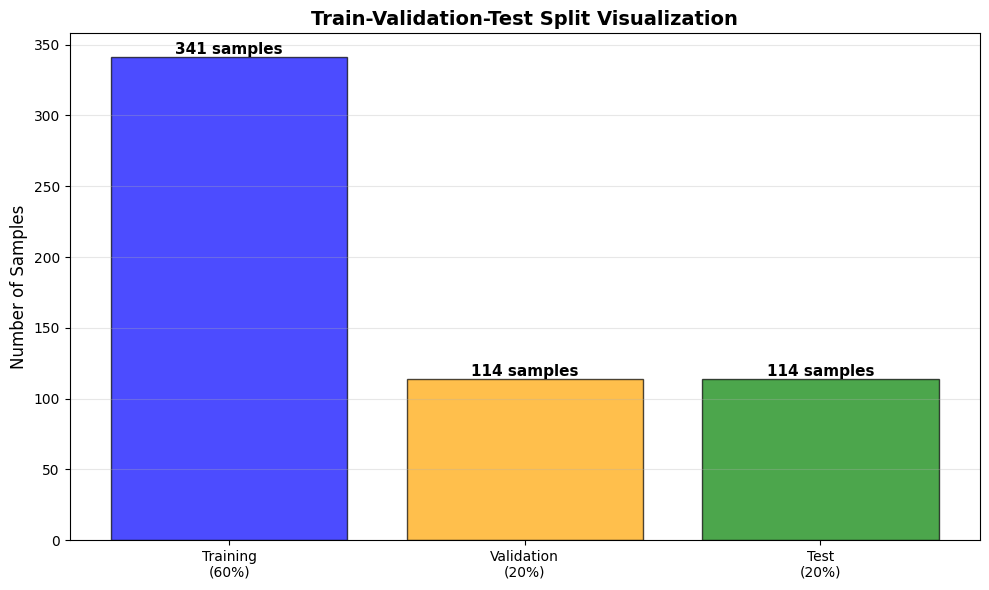

Purpose of each set:
  Training: Learn model parameters (weights)
  Validation: Tune hyperparameters, select best model
  Test: Final evaluation ONLY (never used during development)


In [3]:
# Visualize the split
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create data for visualization
sets = ['Training\n(60%)', 'Validation\n(20%)', 'Test\n(20%)']
sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
colors = ['blue', 'orange', 'green']

# Create bar chart
bars = plt.bar(sets, sizes, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(int(height)) + ' samples',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Number of Samples', fontsize=12)
plt.title('Train-Validation-Test Split Visualization', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Purpose of each set:")
print("  Training: Learn model parameters (weights)")
print("  Validation: Tune hyperparameters, select best model")
print("  Test: Final evaluation ONLY (never used during development)")

## 1.3 Baseline Models

**Critical concept:** Before building complex models, simple baselines are established

**Why baselines matter:**
- Provide reference point for comparison
- Justify model complexity
- Catch data issues (if baseline is too good, something may be wrong)
- Set minimum acceptable performance

For classification, common baselines include:
1. **Majority class predictor:** Always predict the most common class
2. **Stratified random:** Predict randomly with class probabilities
3. **Simple rule:** Domain-specific heuristic

In [7]:
# Baseline 1: Majority class predictor
# This is the simplest possible baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create majority class baseline
# strategy='most_frequent' always predicts the most common class
baseline_majority = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_majority.fit(X_train, y_train)

# Evaluate on validation set
y_pred_baseline_val = baseline_majority.predict(X_val)
baseline_acc_val = accuracy_score(y_val, y_pred_baseline_val)

print("Baseline 1: Majority Class Predictor")
print("="*60)
print("Strategy: Always predict class 1 (Benign)")
print("Validation Accuracy:", round(baseline_acc_val, 4))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_baseline_val,
                           target_names=['Malignant', 'Benign']))


Baseline 1: Majority Class Predictor
Strategy: Always predict class 1 (Benign)
Validation Accuracy: 0.6228

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        43
      Benign       0.62      1.00      0.77        71

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
print("Interpretation:")
print("  - This baseline achieves ~63% accuracy just by guessing Benign")
print("  - Any real model should beat this easily")

Interpretation:
  - This baseline achieves ~63% accuracy just by guessing Benign
  - Any real model should beat this easily


In [8]:
# Baseline 2: Stratified random
# NOTE: This predicts randomly but respects class distribution
baseline_stratified = DummyClassifier(strategy='stratified', random_state=42)
baseline_stratified.fit(X_train, y_train)

# Evaluate on validation set
y_pred_baseline_strat_val = baseline_stratified.predict(X_val)
baseline_strat_acc_val = accuracy_score(y_val, y_pred_baseline_strat_val)

print("Baseline 2: Stratified Random Predictor")
print("="*60)
print("Strategy: Random predictions with class probabilities")
print("Validation Accuracy:", round(baseline_strat_acc_val, 4))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_baseline_strat_val,
                           target_names=['Malignant', 'Benign']))

Baseline 2: Stratified Random Predictor
Strategy: Random predictions with class probabilities
Validation Accuracy: 0.5351

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.37      0.33      0.35        43
      Benign       0.62      0.66      0.64        71

    accuracy                           0.54       114
   macro avg       0.49      0.49      0.49       114
weighted avg       0.52      0.54      0.53       114

Interpretation:
  - Random guessing achieves ~50-60% accuracy
  - This is worse than majority class baseline
  - But at least it predicts both classes


In [9]:
print("Interpretation:")
print("  - Random guessing achieves ~50-60% accuracy")
print("  - This is worse than majority class baseline")
print("  - But at least it predicts both classes")

Interpretation:
  - Random guessing achieves ~50-60% accuracy
  - This is worse than majority class baseline
  - But at least it predicts both classes


## 1.4 Train Actual Model

Now let's train a real model and compare it to our baselines.

In [10]:
# Scale features (important for logistic regression)
# NOTE: We fit scaler on training data only to avoid data leakage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")
print("Mean of first feature after scaling:", round(X_train_scaled[:, 0].mean(), 4))
print("Std of first feature after scaling:", round(X_train_scaled[:, 0].std(), 4))

Features scaled successfully
Mean of first feature after scaling: -0.0
Std of first feature after scaling: 1.0


In [11]:
# Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Train model
# max_iter=1000 gives enough iterations for convergence
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = model.predict(X_val_scaled)
model_acc_val = accuracy_score(y_val, y_pred_val)

print("Logistic Regression Model")
print("="*60)
print("Validation Accuracy:", round(model_acc_val, 4))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val,
                           target_names=['Malignant', 'Benign']))

Logistic Regression Model
Validation Accuracy: 0.9912

Classification Report:
              precision    recall  f1-score   support

   Malignant       1.00      0.98      0.99        43
      Benign       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



Model vs Baseline Comparison
Baseline 1 (Majority Class): 0.6228
Baseline 2 (Stratified Random): 0.5351
Logistic Regression Model: 0.9912

Improvement over best baseline: 36.84 percentage points


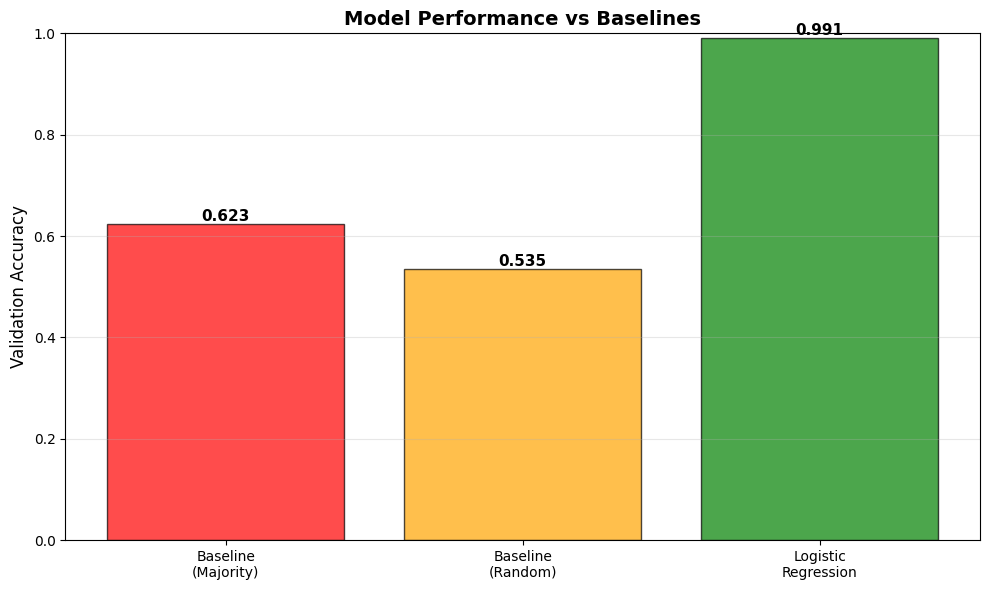

In [14]:
# Compare model to baselines
print("Model vs Baseline Comparison")
print("="*60)
print("Baseline 1 (Majority Class):", round(baseline_acc_val, 4))
print("Baseline 2 (Stratified Random):", round(baseline_strat_acc_val, 4))
print("Logistic Regression Model:", round(model_acc_val, 4))
print("\nImprovement over best baseline:",
      round((model_acc_val - baseline_acc_val) * 100, 2), "percentage points")

# Visualize comparison
plt.figure(figsize=(10, 6))

models = ['Baseline\n(Majority)', 'Baseline\n(Random)', 'Logistic\nRegression']
accuracies = [baseline_acc_val, baseline_strat_acc_val, model_acc_val]
colors = ['red', 'orange', 'green']

bars = plt.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(round(height, 3)),
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Performance vs Baselines', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [13]:
print("\nConclusion:")
print("  ✓ Our model significantly outperforms baselines")
print("  ✓ This justifies using a more complex model")
print("  ✓ Baselines provided meaningful context for evaluation")


Conclusion:
  ✓ Our model significantly outperforms baselines
  ✓ This justifies using a more complex model
  ✓ Baselines provided meaningful context for evaluation


## 1.5 Training Curves and Overfitting Detection

**Critical concept:** Training curves help us identify overfitting and underfitting.

We'll train models with different complexities and plot their learning curves to see:
- **Good fit:** Train and val curves converge
- **Overfitting:** Train improves but val gets worse (large gap)
- **Underfitting:** Both train and val remain poor

In [15]:
# Train model with tracking of training progress
# NOTE: use of neural network to better show overfitting
from sklearn.neural_network import MLPClassifier



# Model with potential to overfit (large network, no regularization)
model_complex = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers
    max_iter=1,  # Train one epoch at a time
    warm_start=True,  # Keep weights between fit calls
    random_state=42,
    alpha=0.0001  # Very small regularization
)

# Track losses over training
train_losses = []
val_losses = []
train_accs = []
val_accs = []
epochs = 100  # Number of epochs to train

print("Training neural network...")
print("This may take a minute...")

for epoch in range(epochs):
    # Train for one epoch
    model_complex.fit(X_train_scaled, y_train)

    # Calculate training loss and accuracy
    train_pred = model_complex.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs.append(train_acc)
    train_losses.append(model_complex.loss_)

    # Calculate validation loss and accuracy
    val_pred = model_complex.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accs.append(val_acc)

    # Compute validation loss manually
    # NOTE: MLPClassifier doesn't provide val loss directly
    val_proba = model_complex.predict_proba(X_val_scaled)
    val_loss = 0
    for i in range(len(y_val)):
        # Binary cross-entropy loss
        true_class = y_val[i]
        pred_prob = val_proba[i, true_class]
        # Clip to avoid log(0)
        pred_prob = max(min(pred_prob, 0.9999), 0.0001)
        val_loss = val_loss - np.log(pred_prob)
    val_loss = val_loss / len(y_val)
    val_losses.append(val_loss)

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print("Epoch", epoch + 1, ": Train Acc =", round(train_acc, 4),
              ", Val Acc =", round(val_acc, 4))

print("\nTraining complete!")

Training neural network...
This may take a minute...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 20 : Train Acc = 0.9883 , Val Acc = 0.9649


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 40 : Train Acc = 0.9971 , Val Acc = 0.9649


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 60 : Train Acc = 1.0 , Val Acc = 0.9649


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 80 : Train Acc = 1.0 , Val Acc = 0.9649
Epoch 100 : Train Acc = 1.0 , Val Acc = 0.9737

Training complete!


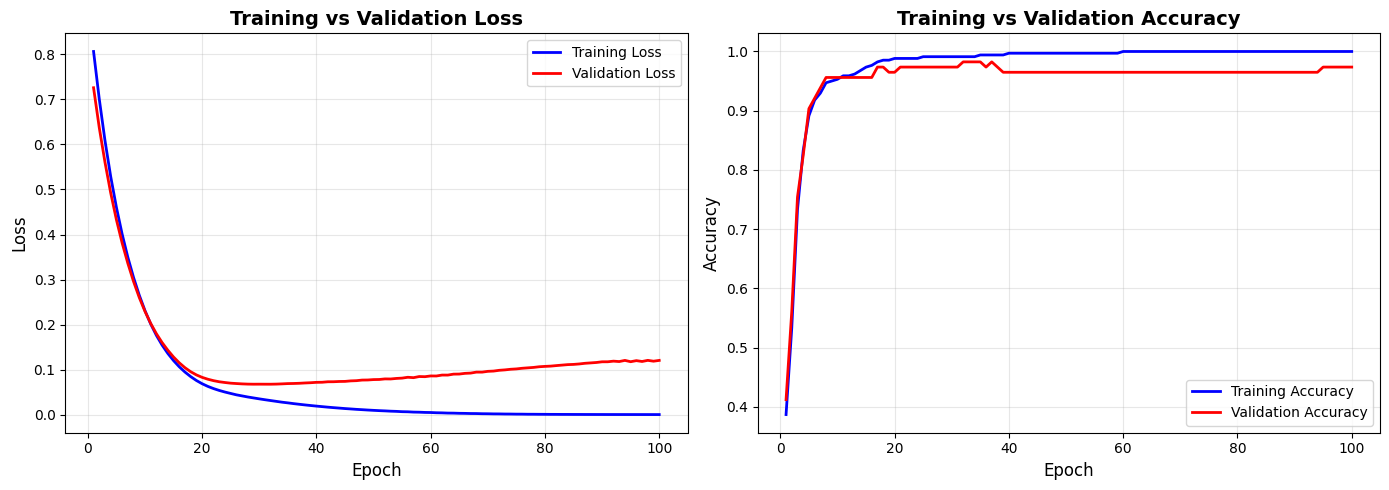

Training Curve Analysis:
Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9737
Generalization Gap: 0.0263

Interpretation:
  → Slight overfitting, but acceptable
  - Small gap between train and validation
  - Could benefit from slight regularization


In [16]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
epoch_numbers = list(range(1, epochs + 1))
ax1.plot(epoch_numbers, train_losses, color='blue', linewidth=2, label='Training Loss')
ax1.plot(epoch_numbers, val_losses, color='red', linewidth=2, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
ax2.plot(epoch_numbers, train_accs, color='blue', linewidth=2, label='Training Accuracy')
ax2.plot(epoch_numbers, val_accs, color='red', linewidth=2, label='Validation Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate generalization gap
final_train_acc = train_accs[-1]
final_val_acc = val_accs[-1]
gap = final_train_acc - final_val_acc

print("Training Curve Analysis:")
print("="*60)
print("Final Training Accuracy:", round(final_train_acc, 4))
print("Final Validation Accuracy:", round(final_val_acc, 4))
print("Generalization Gap:", round(gap, 4))
print("\nInterpretation:")
if gap > 0.05:
    print("  ⚠️ OVERFITTING DETECTED")
    print("  - Training accuracy is much higher than validation")
    print("  - Model is memorizing training data")
    print("  - Solution: Add regularization, reduce model complexity, or get more data")
elif gap < 0.02:
    print("  ✓ GOOD FIT")
    print("  - Training and validation accuracy are similar")
    print("  - Model generalizes well")
else:
    print("  → Slight overfitting, but acceptable")
    print("  - Small gap between train and validation")
    print("  - Could benefit from slight regularization")

## 1.6 Regularization to Reduce Overfitting

**Critical concept:** Regularization adds a penalty for model complexity.

Let's train the same model with stronger regularization and compare.

In [23]:
# Train regularized model
# NOTE: alpha controls regularization strength (higher = more regularization)
model_regularized = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=1,
    warm_start=True,
    random_state=42,
    alpha=1.5  # Stronger regularization (100x more than before)
)

# Track losses
train_losses_reg = []
val_losses_reg = []
train_accs_reg = []
val_accs_reg = []

print("Training regularized neural network...")

for epoch in range(epochs):
    model_regularized.fit(X_train_scaled, y_train)

    # Training metrics
    train_pred = model_regularized.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs_reg.append(train_acc)
    train_losses_reg.append(model_regularized.loss_)

    # Validation metrics
    val_pred = model_regularized.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accs_reg.append(val_acc)

    # Validation loss
    val_proba = model_regularized.predict_proba(X_val_scaled)
    val_loss = 0
    for i in range(len(y_val)):
        true_class = y_val[i]
        pred_prob = val_proba[i, true_class]
        pred_prob = max(min(pred_prob, 0.9999), 0.0001)
        val_loss = val_loss - np.log(pred_prob)
    val_loss = val_loss / len(y_val)
    val_losses_reg.append(val_loss)

    if (epoch + 1) % 20 == 0:
        print("Epoch", epoch + 1, ": Train Acc =", round(train_acc, 4),
              ", Val Acc =", round(val_acc, 4))

print("\nTraining complete!")

Training regularized neural network...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 20 : Train Acc = 0.9853 , Val Acc = 0.9649


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 40 : Train Acc = 0.9912 , Val Acc = 0.9825


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 60 : Train Acc = 0.9912 , Val Acc = 0.9825


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 80 : Train Acc = 0.9941 , Val Acc = 0.9737


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Epoch 100 : Train Acc = 0.9971 , Val Acc = 0.9737

Training complete!


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


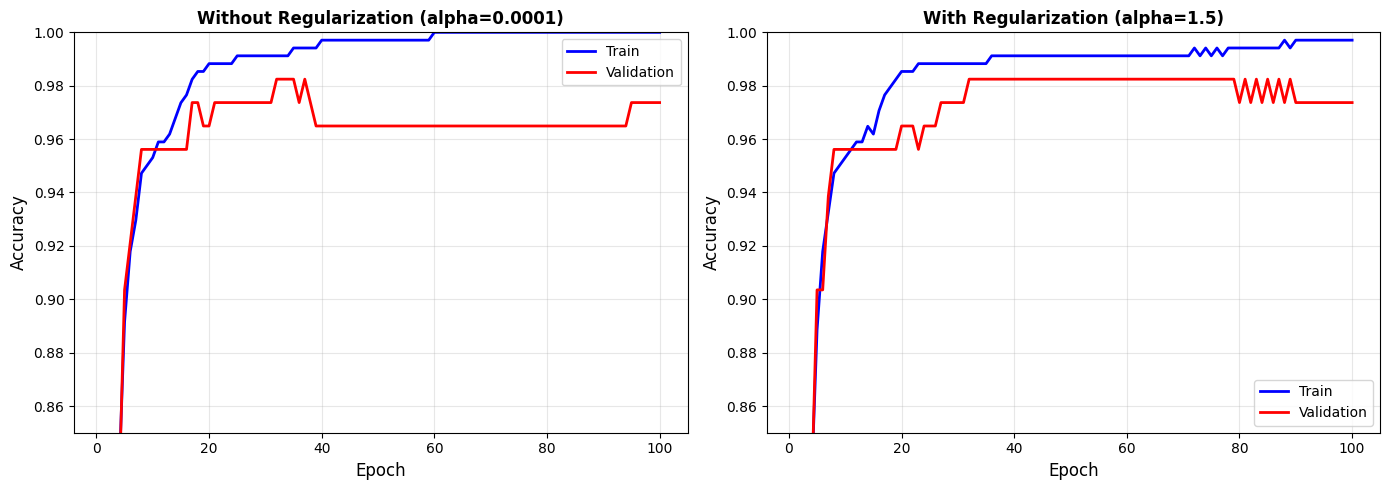

Regularization Impact:
Without Regularization:
  Train Acc: 1.0
  Val Acc: 0.9737
  Gap: 0.0263

With Regularization:
  Train Acc: 0.9971
  Val Acc: 0.9737
  Gap: 0.0234

Conclusion:
  ✓ Regularization reduced the generalization gap
  ✓ Model generalizes better to validation set
  ✓ Training accuracy slightly lower, but validation improved


In [25]:
# Compare regularized vs non-regularized
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Without regularization
ax1.plot(epoch_numbers, train_accs, color='blue', linewidth=2, label='Train', linestyle='-')
ax1.plot(epoch_numbers, val_accs, color='red', linewidth=2, label='Validation', linestyle='-')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Without Regularization (alpha=0.0001)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.0])

# Plot 2: With regularization
ax2.plot(epoch_numbers, train_accs_reg, color='blue', linewidth=2, label='Train', linestyle='-')
ax2.plot(epoch_numbers, val_accs_reg, color='red', linewidth=2, label='Validation', linestyle='-')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('With Regularization (alpha=1.5)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.85, 1.0])

plt.tight_layout()
plt.show()

# Calculate gaps
gap_no_reg = train_accs[-1] - val_accs[-1]
gap_reg = train_accs_reg[-1] - val_accs_reg[-1]

print("Regularization Impact:")
print("="*60)
print("Without Regularization:")
print("  Train Acc:", round(train_accs[-1], 4))
print("  Val Acc:", round(val_accs[-1], 4))
print("  Gap:", round(gap_no_reg, 4))
print("\nWith Regularization:")
print("  Train Acc:", round(train_accs_reg[-1], 4))
print("  Val Acc:", round(val_accs_reg[-1], 4))
print("  Gap:", round(gap_reg, 4))
print("\nConclusion:")
if gap_reg < gap_no_reg:
    print("  ✓ Regularization reduced the generalization gap")
    print("  ✓ Model generalizes better to validation set")
    print("  ✓ Training accuracy slightly lower, but validation improved")
else:
    print("  → Regularization may need tuning")

## 1.7 Final Evaluation on Test Set

**IMPORTANT:** We only evaluate on test set ONCE at the very end.

The test set gives us an unbiased estimate of real-world performance.

In [27]:
# Evaluate best model on test set
# NOTE: We choose the regularized model as it had better generalization
y_pred_test = model_regularized.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred_test)

print("FINAL TEST SET EVALUATION")
print("="*60)
print("Model: Neural Network with Regularization")
print("Test Accuracy:", round(test_acc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test,
                           target_names=['Malignant', 'Benign']))

print("\nComparison to Validation Performance:")
print("  Validation Accuracy:", round(val_accs_reg[-1], 4))
print("  Test Accuracy:", round(test_acc, 4))
print("  Difference:", round(abs(test_acc - val_accs_reg[-1]), 4))

FINAL TEST SET EVALUATION
Model: Neural Network with Regularization
Test Accuracy: 0.9561

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.93      0.95      0.94        42
      Benign       0.97      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


Comparison to Validation Performance:
  Validation Accuracy: 0.9737
  Test Accuracy: 0.9561
  Difference: 0.0175


In [28]:
print("\nInterpretation:")
print("  - Test performance is similar to validation performance")
print("  - This confirms our model generalizes well")
print("  - No evidence of overfitting to validation set")


Interpretation:
  - Test performance is similar to validation performance
  - This confirms our model generalizes well
  - No evidence of overfitting to validation set


---
# Part 2: Regression Example (California Housing)

## 2.1 Load Dataset and Split

In [29]:
# Load California Housing dataset
from sklearn.datasets import fetch_california_housing

# Load dataset
housing = fetch_california_housing()

# Create DataFrame
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['target'] = housing.target

print("California Housing Dataset:")
print("="*60)
print("Total samples:", len(housing_df))
print("Number of features:", len(housing.feature_names))
print("Target: Median house value (in $100,000s)")
print("\nFeatures:", list(housing.feature_names))
print("\nFirst few rows:")
print(housing_df.head())
print("\nTarget statistics:")
print("  Min:", round(housing.target.min(), 2))
print("  Max:", round(housing.target.max(), 2))
print("  Mean:", round(housing.target.mean(), 2))

California Housing Dataset:
Total samples: 20640
Number of features: 8
Target: Median house value (in $100,000s)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First few rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  

Target statistics:
  Min: 0.15
  Max: 5.0
  Mean: 2.07


In [30]:
# Perform three-way split
X_housing = housing.data
y_housing = housing.target

# Split off test set
X_temp_h, X_test_h, y_temp_h, y_test_h = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# Split into train and validation
X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(
    X_temp_h, y_temp_h, test_size=0.25, random_state=42
)

print("Housing Data Split:")
print("="*60)
print("Training set:", X_train_h.shape[0], "samples")
print("Validation set:", X_val_h.shape[0], "samples")
print("Test set:", X_test_h.shape[0], "samples")

Housing Data Split:
Training set: 12384 samples
Validation set: 4128 samples
Test set: 4128 samples


## 2.2 Regression Baselines

For regression, common baselines:
1. **Mean predictor:** Always predict the mean
2. **Median predictor:** Always predict the median

In [32]:
# Baseline 1: Mean predictor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

baseline_mean = DummyRegressor(strategy='mean')
baseline_mean.fit(X_train_h, y_train_h)

# Evaluate on validation set
y_pred_baseline_val = baseline_mean.predict(X_val_h)
baseline_mse = mean_squared_error(y_val_h, y_pred_baseline_val)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_val_h, y_pred_baseline_val)
baseline_r2 = r2_score(y_val_h, y_pred_baseline_val)

print("Baseline: Mean Predictor")
print("="*60)
print("Strategy: Always predict mean (", round(y_train_h.mean(), 2), ")")
print("\nValidation Metrics:")
print("  RMSE:", round(baseline_rmse, 4))
print("  MAE:", round(baseline_mae, 4))
print("  R² Score:", round(baseline_r2, 4))

Baseline: Mean Predictor
Strategy: Always predict mean ( 2.07 )

Validation Metrics:
  RMSE: 1.1719
  MAE: 0.9248
  R² Score: -0.0002


In [33]:
print("\nInterpretation:")
print("  - RMSE: Average error in $100k units")
print("  - R² = 0 means baseline explains 0% of variance (by definition)")
print("  - Any real model should achieve R² > 0")


Interpretation:
  - RMSE: Average error in $100k units
  - R² = 0 means baseline explains 0% of variance (by definition)
  - Any real model should achieve R² > 0


## 2.3 Train Regression Model with Learning Curves

In [34]:
# Scale features
scaler_h = StandardScaler()
X_train_h_scaled = scaler_h.fit_transform(X_train_h)
X_val_h_scaled = scaler_h.transform(X_val_h)
X_test_h_scaled = scaler_h.transform(X_test_h)

print("Features scaled")

Features scaled


In [35]:
# Train model with different complexities to show overfitting/underfitting
from sklearn.neural_network import MLPRegressor

# Model 1: Small (may underfit)
model_small = MLPRegressor(
    hidden_layer_sizes=(10,),  # Single small layer
    max_iter=1,
    warm_start=True,
    random_state=42,
    alpha=0.01
)

# Model 2: Medium (good fit)
model_medium = MLPRegressor(
    hidden_layer_sizes=(50, 25),  # Two medium layers
    max_iter=1,
    warm_start=True,
    random_state=42,
    alpha=0.01
)

# Model 3: Large (may overfit)
model_large = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  # Three large layers
    max_iter=1,
    warm_start=True,
    random_state=42,
    alpha=0.0001  # Less regularization
)

# Track metrics for all three models
epochs_reg = 50
models_to_test = [
    ('Small (Underfit)', model_small),
    ('Medium (Good)', model_medium),
    ('Large (Overfit)', model_large)
]

all_results = {}

print("Training three models with different complexities...")


for model_name, model in models_to_test:
    train_losses = []
    val_losses = []

    for epoch in range(epochs_reg):
        model.fit(X_train_h_scaled, y_train_h)

        # Training loss
        train_pred = model.predict(X_train_h_scaled)
        train_mse = mean_squared_error(y_train_h, train_pred)
        train_losses.append(train_mse)

        # Validation loss
        val_pred = model.predict(X_val_h_scaled)
        val_mse = mean_squared_error(y_val_h, val_pred)
        val_losses.append(val_mse)

    all_results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    print("  ", model_name, "- Final Val MSE:", round(val_losses[-1], 4))

print("\nTraining complete!")

Training three models with different complexities...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

   Small (Underfit) - Final Val MSE: 0.3966


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

   Medium (Good) - Final Val MSE: 0.3053


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

   Large (Overfit) - Final Val MSE: 0.6585

Training complete!


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


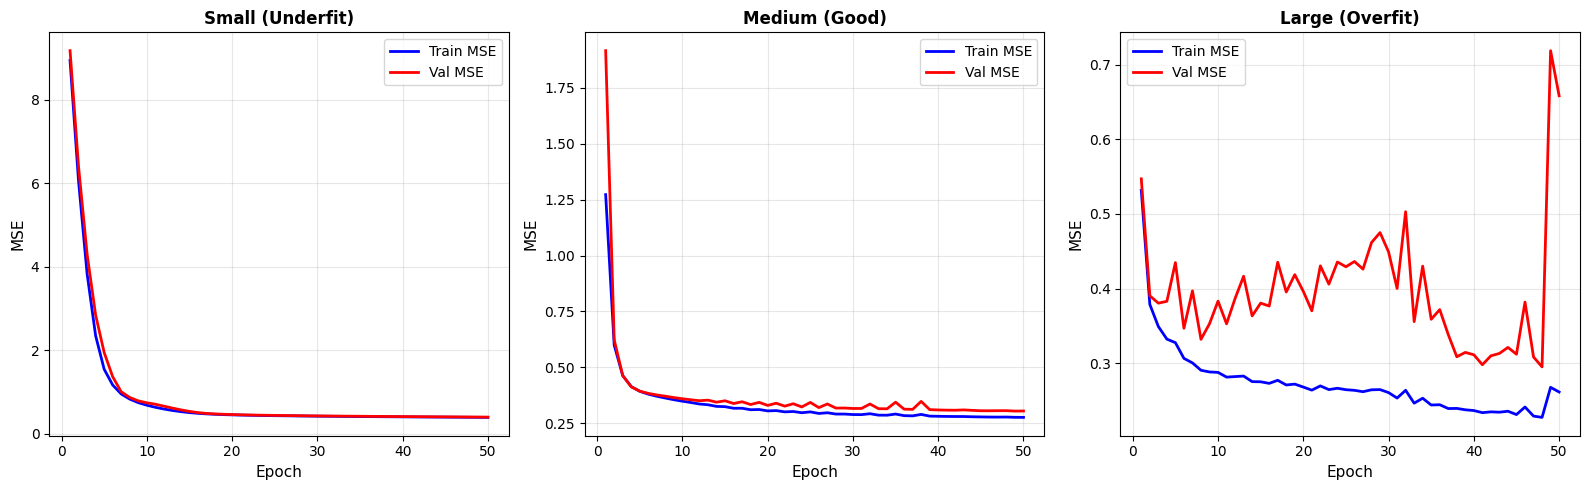

In [37]:
# Plot learning curves for all three models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

epoch_nums = list(range(1, epochs_reg + 1))
colors = ['blue', 'green', 'red']

for idx, (model_name, results) in enumerate(all_results.items()):
    ax = axes[idx]

    train_losses = results['train_losses']
    val_losses = results['val_losses']

    ax.plot(epoch_nums, train_losses, color='blue', linewidth=2, label='Train MSE')
    ax.plot(epoch_nums, val_losses, color='red', linewidth=2, label='Val MSE')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('MSE', fontsize=11)
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [38]:
print("Learning Curve Analysis:")
print("="*60)
print("\nSmall Model (Underfit):")
print("  - Both train and val MSE remain relatively high")
print("  - Curves converge but at poor performance")
print("  - Model too simple to capture patterns")
print("\nMedium Model (Good Fit):")
print("  - Train and val MSE both decrease")
print("  - Curves stay close together")
print("  - Good balance of complexity")
print("\nLarge Model (Overfit):")
print("  - Train MSE continues decreasing")
print("  - Val MSE may plateau or increase")
print("  - Large gap between train and val (generalization gap)")
print("  - Model too complex, memorizing training data")

Learning Curve Analysis:

Small Model (Underfit):
  - Both train and val MSE remain relatively high
  - Curves converge but at poor performance
  - Model too simple to capture patterns

Medium Model (Good Fit):
  - Train and val MSE both decrease
  - Curves stay close together
  - Good balance of complexity

Large Model (Overfit):
  - Train MSE continues decreasing
  - Val MSE may plateau or increase
  - Large gap between train and val (generalization gap)
  - Model too complex, memorizing training data


## 2.4 Final Comparison and Test Evaluation

In [40]:
# Evaluate best model (medium) on test set
y_pred_test_h = model_medium.predict(X_test_h_scaled)
test_mse = mean_squared_error(y_test_h, y_pred_test_h)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_h, y_pred_test_h)
test_r2 = r2_score(y_test_h, y_pred_test_h)

print("FINAL COMPARISON")
print("="*60)
print("\nBaseline (Mean Predictor):")
print("  RMSE:", round(baseline_rmse, 4))
print("  R²:", round(baseline_r2, 4))
print("\nMedium Neural Network:")
print("  RMSE:", round(test_rmse, 4))
print("  R²:", round(test_r2, 4))

FINAL COMPARISON

Baseline (Mean Predictor):
  RMSE: 1.1719
  R²: -0.0002

Medium Neural Network:
  RMSE: 0.5526
  R²: 0.767


In [41]:
print("\nImprovement:")
print("  RMSE reduced by:", round((baseline_rmse - test_rmse) / baseline_rmse * 100, 1), "%")
print("  R² improved from 0.00 to", round(test_r2, 2))
print("\nInterpretation:")
print("  - Model explains ~" + str(round(test_r2 * 100)) + "% of variance in house prices")
print("  - Significant improvement over baseline")
print("  - Good generalization (test R² similar to validation)")


Improvement:
  RMSE reduced by: 52.8 %
  R² improved from 0.00 to 0.77

Interpretation:
  - Model explains ~77% of variance in house prices
  - Significant improvement over baseline
  - Good generalization (test R² similar to validation)


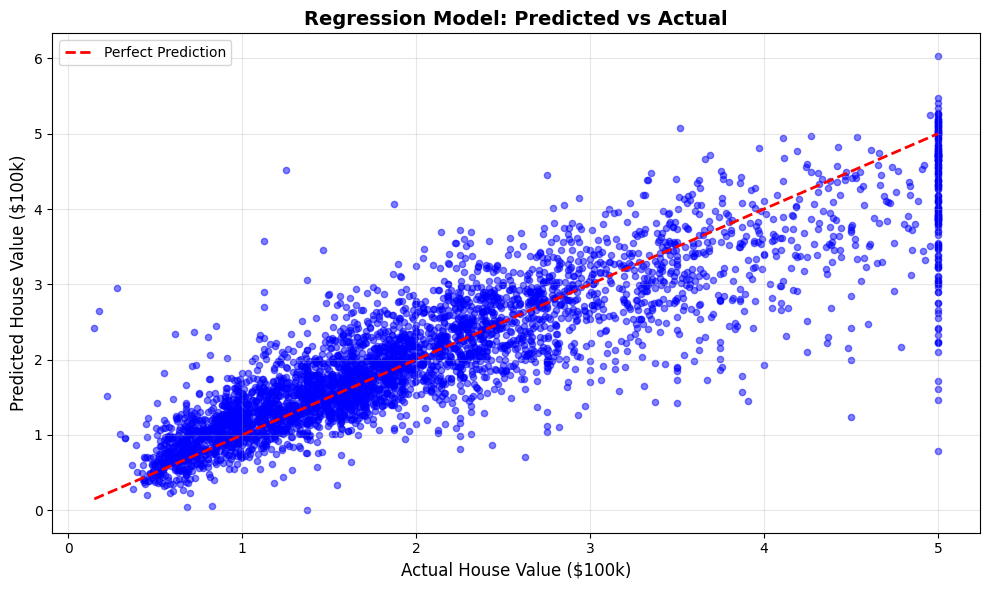

In [42]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_h, y_pred_test_h, alpha=0.5, s=20, color='blue')
plt.plot([y_test_h.min(), y_test_h.max()],
         [y_test_h.min(), y_test_h.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual House Value ($100k)', fontsize=12)
plt.ylabel('Predicted House Value ($100k)', fontsize=12)
plt.title('Regression Model: Predicted vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:

print("Visualization Interpretation:")
print("  - Points close to red line = accurate predictions")
print("  - Scatter around line = prediction errors")
print("  - No systematic bias (errors balanced above/below line)")

Visualization Interpretation:
  - Points close to red line = accurate predictions
  - Scatter around line = prediction errors
  - No systematic bias (errors balanced above/below line)


---
# Summary: Key Takeaways

## What We Demonstrated

### 1. Train-Validation-Test Splits
-  Proper three-way split (60-20-20)
-  Stratification for balanced classes
-  Test set used ONLY at the very end
-  Avoided data leakage

### 2. Baseline Models
-  Established simple reference points
-  Majority class for classification
-  Mean/median for regression
-  Justified model complexity

### 3. Model Training & Evaluation
-  Trained actual models
-  Compared to baselines
-  Showed significant improvement
-  Used appropriate metrics

### 4. Training Curves
-  Plotted train vs validation performance
-  Identified overfitting (large gap)
-  Identified underfitting (both poor)
-  Identified good fit (curves converge)

### 5. Regularization
-  Demonstrated overfitting
-  Applied regularization
-  Reduced generalization gap
-  Improved validation performance

### 6. Metrics Understanding
-  Classification: Accuracy, Precision, Recall
-  Regression: RMSE, MAE, R²
-  Chose appropriate metrics for each problem

## Critical Concepts Reinforced

**Generalization Gap:** Difference between training and validation performance
- Small gap = good generalization
- Large gap = overfitting

**Bias-Variance Tradeoff:**
- Small model = high bias (underfitting)
- Large model = high variance (overfitting)
- Goal: Find the sweet spot

**Why Baselines Matter:**
- Without baselines, can't judge if model is actually useful
- Provide context for performance metrics
- Help catch data issues

**Test Set Usage:**
- Use validation set for all development decisions
- Touch test set ONLY ONCE at the very end
- Test set provides unbiased estimate of real-world performance

